<a href="https://colab.research.google.com/github/Yagwar/Sociadisticas/blob/master/alc_bog_load_JSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.style.use('seaborn-talk')
%matplotlib inline

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = 'gdrive/My Drive/Freelancer/alc_bog_19/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cuentas=["ClaudiaLopez","carlosfgalan","angelamrobledo","MiguelUribeT","angelagarzonc",
         "luchogarzon","hollmanmorris","MAndreaNieto","CelioNievesH","jerojasrodrigue",
         "LuisErnestoGL"]
ids_cands=["137908875","64791701","165748292","163341528","325856294",
           "60161414","87266285","999594384","240409671","233001872",
           "2499219806"]

# Loader

In [0]:
#get users and mentions from the download files:
tweets_datas_path = [drive_path+"candidatos_alcaldia_0.json",
                     drive_path+"candidatos_alcaldia_1.json"]
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]
tw_device=[]# print(twits[rnd_ind]["source"])
tw_date=[]# print(twits[rnd_ind]["created_at"])


for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop[0]])
                tw_device.append(tweet["source"])
                tw_date.append(tweet["created_at"])
            except:
                continue

In [5]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n",
      "Tweets con dispositivos registrado  :",len(tw_device),"\n",
      "Tweets con fechas registradas       :",len(tw_date),"\n"
     )

Tweets identificados con código     : 426499 
 Tweets con usuario identificado     : 426499 
 Tweets con nombre de usuario        : 426499 
 Textos de tweets recuperados        : 426499 
 Total de Menciones en los tweets    : 2415298 
 Tweets con menciones identificadas  : 426499 
 Tweets con dispositivos registrado  : 426499 
 Tweets con fechas registradas       : 426499 



In [0]:
tw_device=[dvc[dvc.find(">")+1:dvc.find("<",2)] for dvc in tw_device]
tw_text=np.array(tw_text)

### Tabla de menciones

In [0]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [8]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 25854


In [0]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")
# se utiliza el código para evitar conteos por homónimos

In [10]:
id_ments.head()


col_0,count
row_0,
137908875,229398
49849732,64052
165748292,60799
87266285,57494
163341528,52374


In [0]:
top_n=150


In [0]:
ments_ids_top=list(id_ments.index[:top_n])

In [0]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])
mntns_candts=np.array([[cand in tw_mntns[2] for cand in ids_cands]for tw_mntns in mentioned_ids])

In [14]:
print(mntns_top_ocurr.shape)
print(mntns_candts.shape)

(426499, 150)
(426499, 11)


In [0]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [0]:
# twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=tw_id)
df_mntns_candts=pd.DataFrame(mntns_candts,columns=cuentas, index=tw_id)

In [17]:
print(df_mntns_top_ocurr.shape)
print(df_mntns_candts.shape)

(426499, 150)
(426499, 11)


In [18]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 67449


row_0
Twitter for Android        264400
Twitter for iPhone          90758
Twitter Web App             33441
Twitter Web Client          30246
Twitter for iPad             5790
TweetDeck                     778
Pypbot                        508
Mobile Web (M2)               190
TweetCaster for Android        49
Facebook                       38
Name: count, dtype: int64

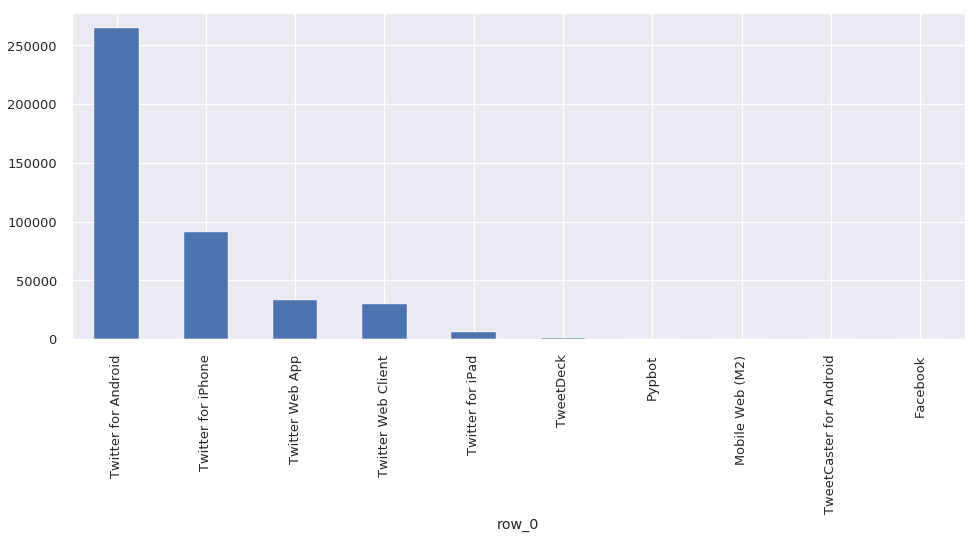

In [19]:
devices=pd.crosstab(index=np.array(tw_device), columns="count")
devices=devices.sort_values(by=['count'] , ascending=False)["count"]
devices[:10].plot(figsize=(16, 6), kind="bar")
devices[:10]

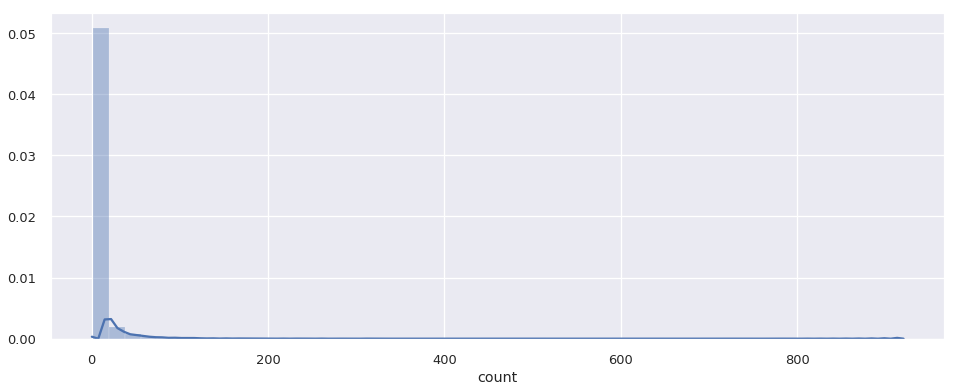

In [20]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [21]:
round(ids_freqs.describe(),3)

count    67449.000
mean         6.323
std         18.351
min          1.000
25%          1.000
50%          2.000
75%          4.000
max        920.000
Name: count, dtype: float64

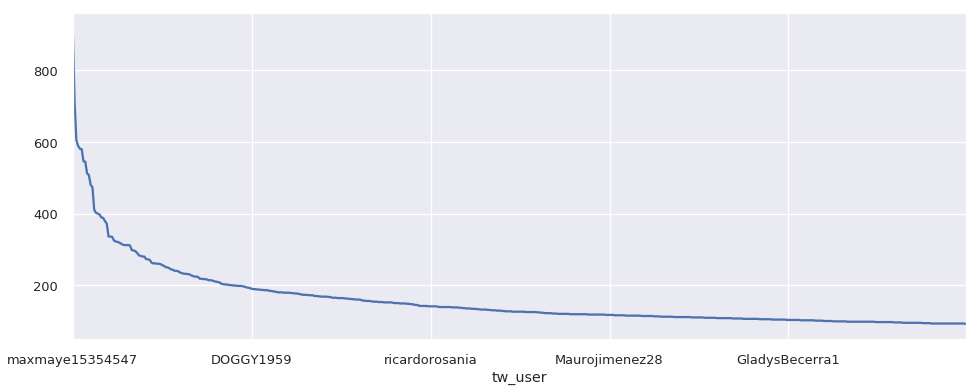

In [23]:
ids_freqs[:500].plot(figsize=(16, 6))

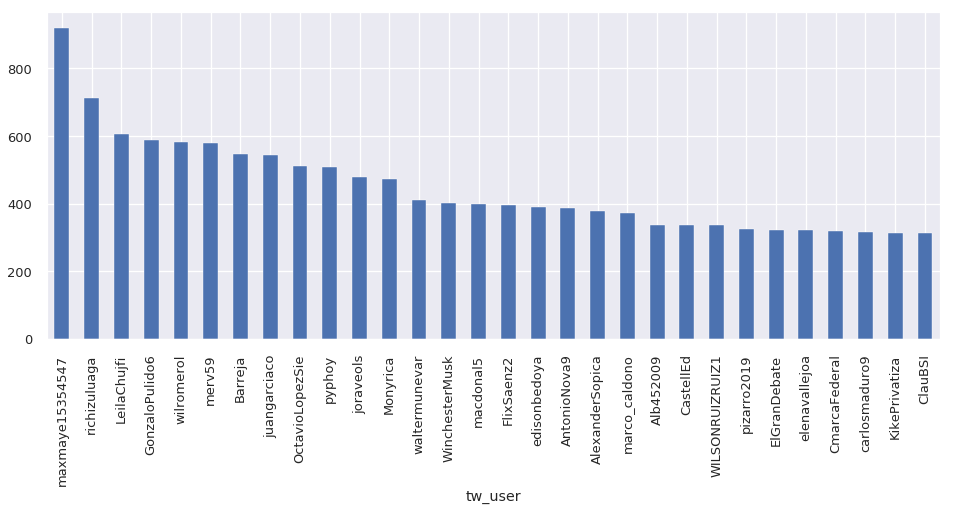

In [24]:
ids_freqs[:30].plot(figsize=(16, 6), kind="bar")
plt.savefig(drive_path+'top_tweeters.png')

In [25]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
maxmaye15354547    920
richizuluaga       714
LeilaChujfi        605
GonzaloPulido6     589
wilromerol         581
merv59             580
Barreja            546
juangarciaco       545
OctavioLopezSie    512
pyphoy             508
joraveols          480
Monyrica           474
waltermunevar      410
WinchesterMusk     402
macdonal5          400
FlixSaenz2         397
edisonbedoya       389
AntonioNova9       388
AlexanderSopica    379
marco_caldono      372
Alb452009          336
CastellEd          336
WILSONRUIZRUIZ1    335
pizarro2019        325
ElGranDebate       322
elenavallejoa      321
CmarcaFederal      319
carlosmaduro9      316
KikePrivatiza      313
ClauBSI            312
GarciaColorad0     312
helmanzano         312
AGtavo1            311
WILBERGB           298
nervencid          297
HefzibaInes        295
lufranlou          290
ktina_mejia        283
humanorururbano    282
titaniavillalba    280
marianagoyenec2    280
neoflash5          273
LuisEdu620829      272
Sol

In [26]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

25752

ClaudiaLopez       229398
petrogustavo        64052
angelamrobledo      60799
HOLLMANMORRIS       57494
MiguelUribeT        52374
GustavoBolivar      27653
EnriquePenalosa     27143
LuisErnestoGL       23306
jerojasrodrigue     21556
carlosfgalan        21335
angelagarzonc       19894
IvanDuque           16969
CarlosCarrilloA     14718
GNavasTalero        14564
CConstitucional     12931
CelioNievesH        12372
PizarroMariaJo      12329
AngelicaLozanoC     12278
AidaAvellaE         12122
DavidRacero         11286
dtype: int64


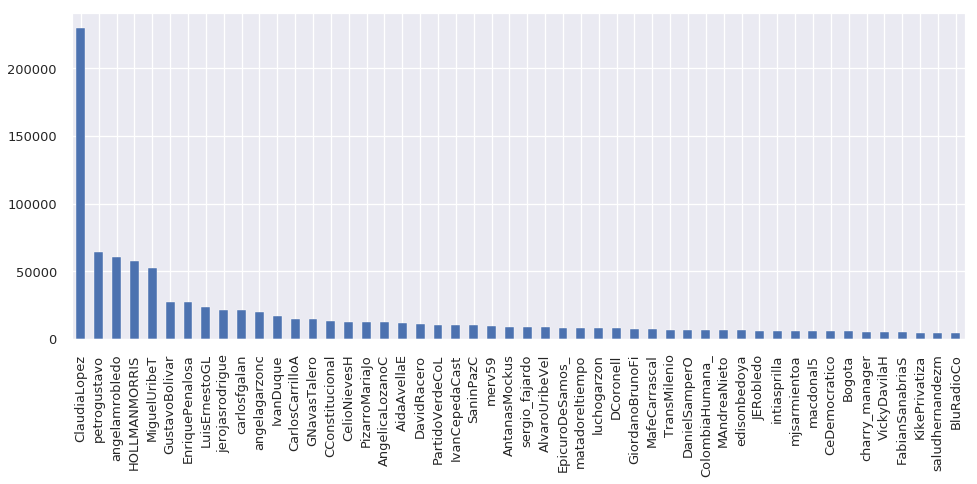

In [27]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'top_mentions.png')

ClaudiaLopez       229398
angelamrobledo      60799
hollmanmorris       57494
MiguelUribeT        52374
LuisErnestoGL       23306
jerojasrodrigue     21556
carlosfgalan        21335
angelagarzonc       19894
CelioNievesH        12372
luchogarzon          7884
MAndreaNieto         6254
dtype: int64


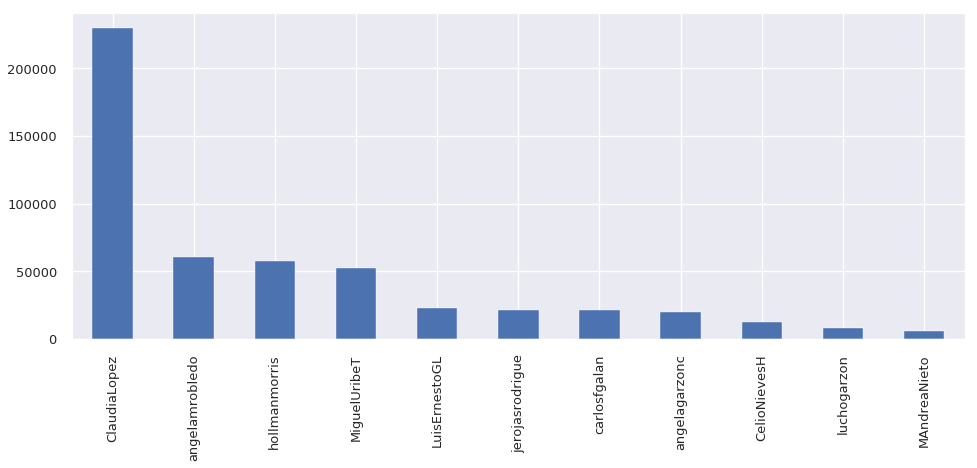

In [28]:
plt.figure(figsize=(16,6))
print (df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'df_mntns_candts.png')

# Relaciones de cuentas

In [0]:
directed_graph_df=df_mntns_top_ocurr.groupby(tw_user).aggregate(sum)
mat_dendr=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr.sample(20)

In [0]:
ments_ward= hierarchy.linkage(mat_dendr.transpose(), 'ward')

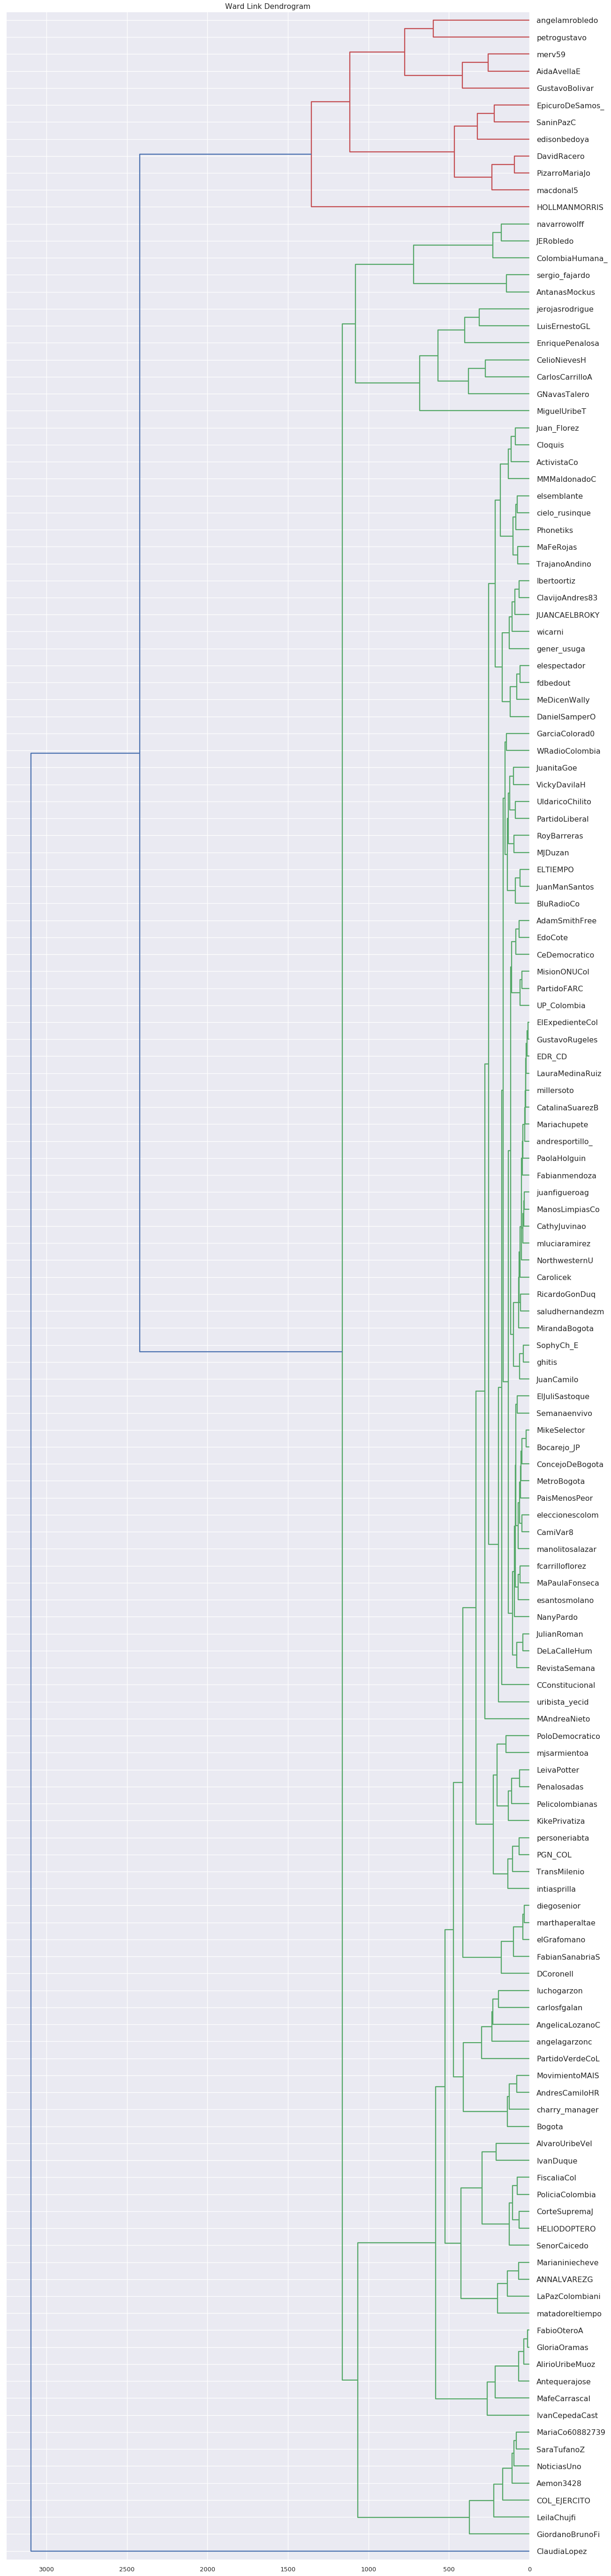

In [31]:
plt.figure(figsize=(20,100))
dn = hierarchy.dendrogram(ments_ward,orientation="left", labels=df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False).index)
plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'ments_dendrograma_ward.png')
plt.show()

In [0]:
directed_graph_df_candts=df_mntns_candts.groupby(tw_user).aggregate(sum)
mat_dendr_candts=directed_graph_df_candts.loc[directed_graph_df_candts.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr_candts.sample(20)

In [0]:
cands_ward= hierarchy.linkage(mat_dendr_candts.transpose(), 'ward')

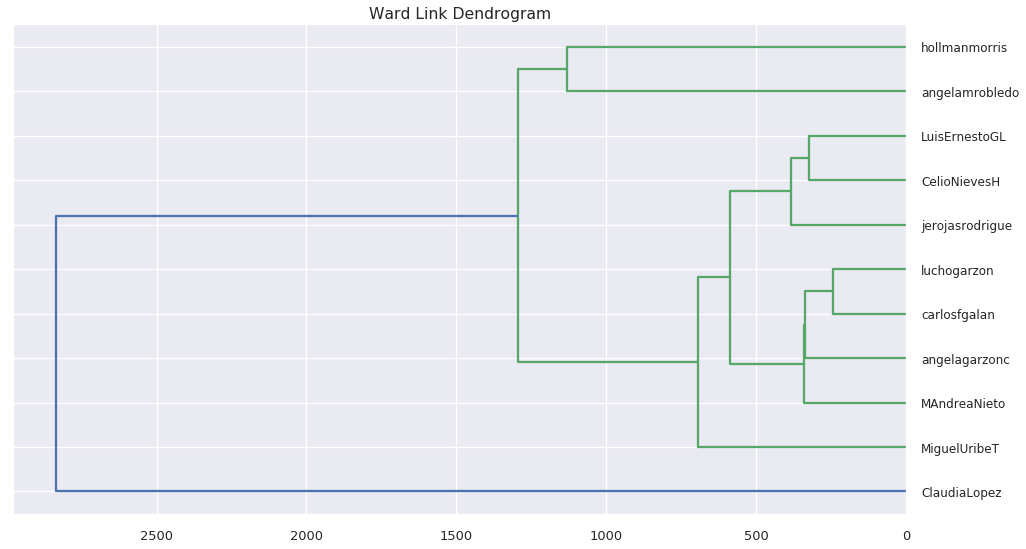

In [34]:
plt.figure(figsize=(16,9))
dn = hierarchy.dendrogram(cands_ward,orientation="left", labels=cuentas)
# plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'cands_dendrograma_ward.png')
plt.show()

# Temporalidad

In [0]:
tw_fechas_df=pd.DataFrame(np.column_stack([tw_user,tw_date]))
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [0]:
time_sample="3600s"#'1440T'#"1800S"#"900S"#"3600s"#

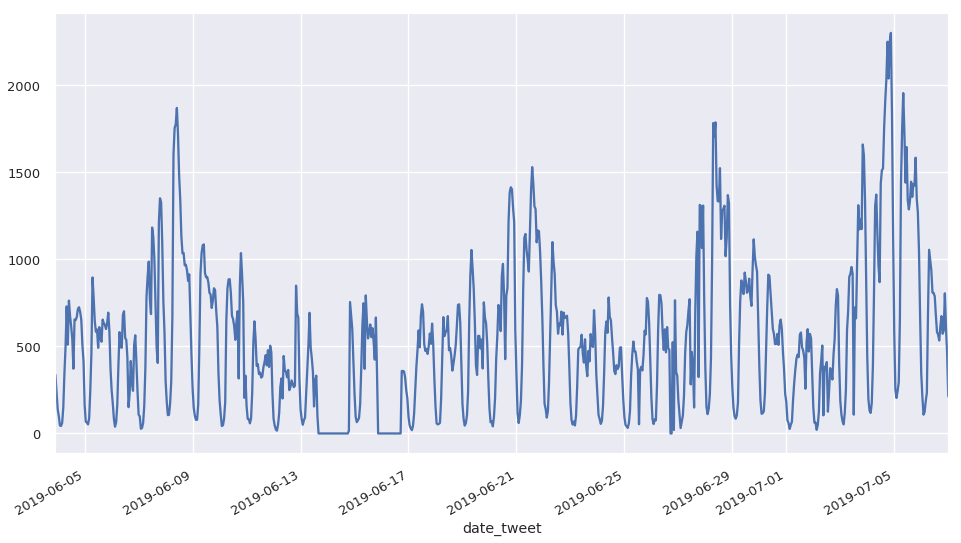

In [37]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

## Menciones

In [0]:
mayor_tweeters=list(directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:10])

In [0]:
tw_fechas_df_top=tw_fechas_df[tw_fechas_df.user.isin(mayor_tweeters)]

In [0]:
twits_filt=pd.crosstab(index=tw_fechas_df_top.index,
                  columns=tw_fechas_df_top["user"])
twits_filt=twits_filt.resample(time_sample).sum()

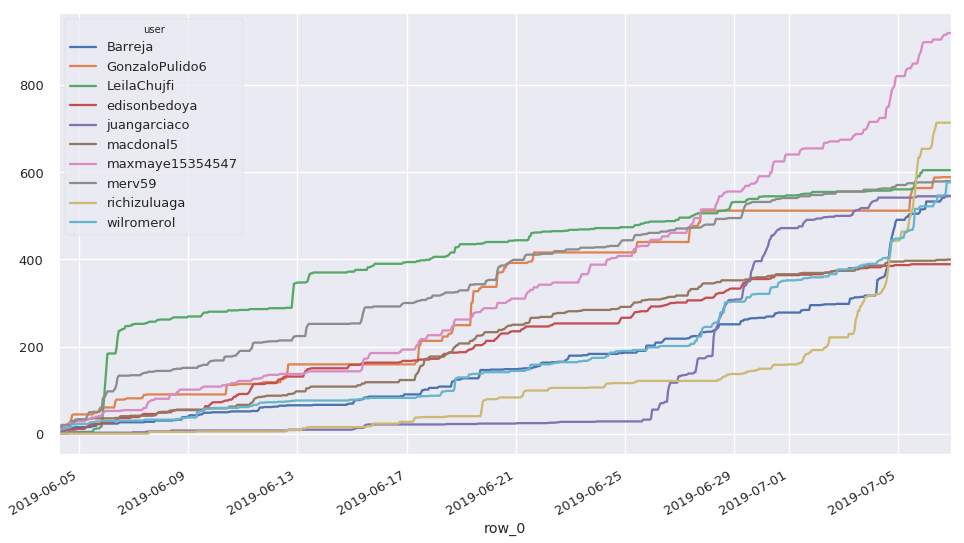

In [41]:
twits_filt.cumsum().plot(figsize=(16,9))

In [0]:
top_ments_df=df_mntns_top_ocurr.copy()*1
top_ments_df.index=tw_fechas_df.index
# top_ments_df.head(20)

In [0]:
top_ments_df_day=top_ments_df.iloc[:,:10].resample(time_sample).sum()

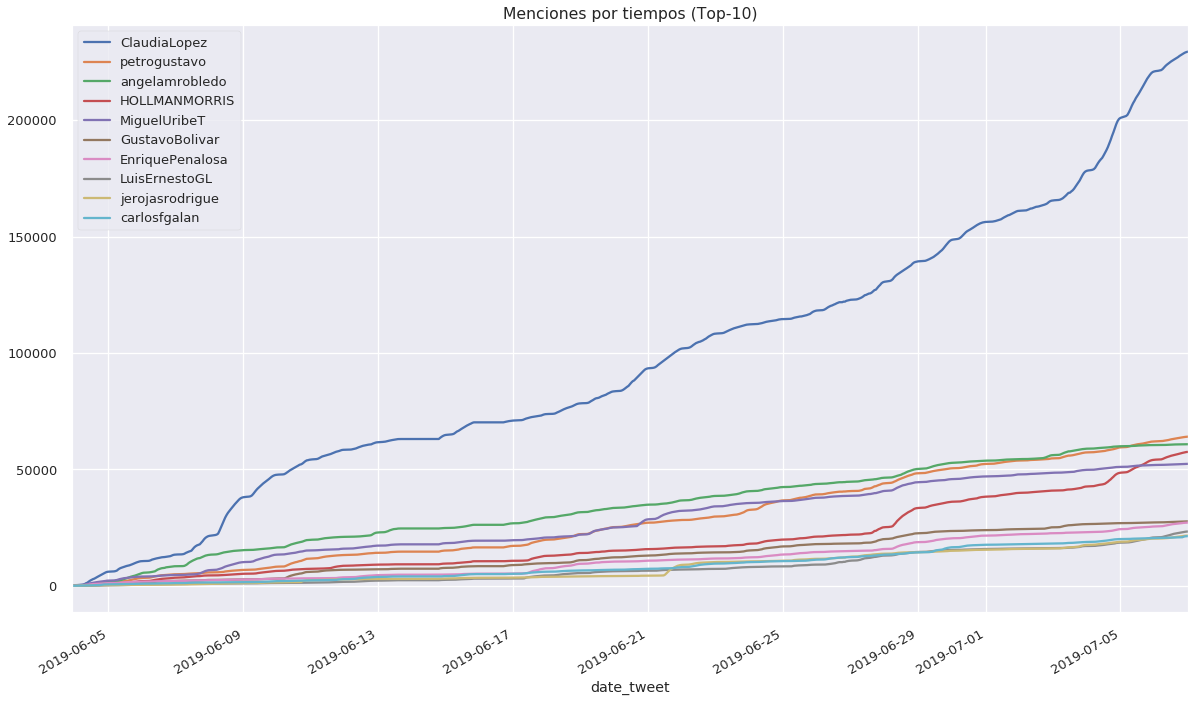

In [44]:
top_ments_df_day.cumsum().plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

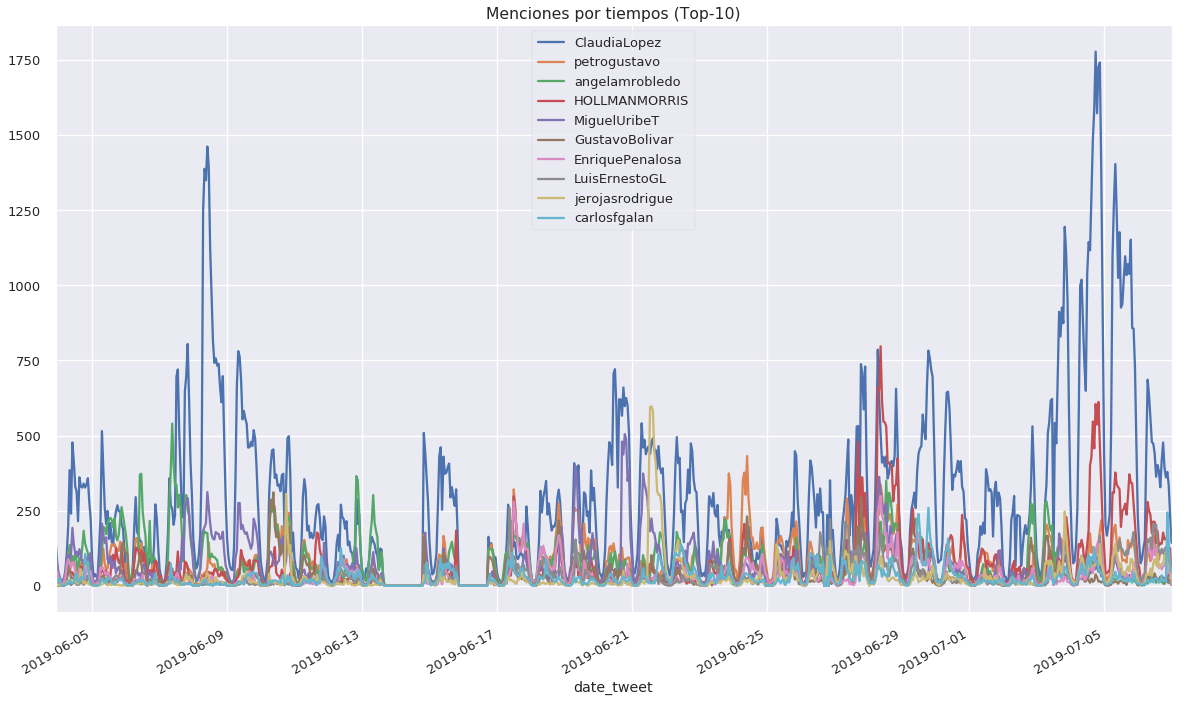

In [45]:
top_ments_df_day.plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

## Candidatos

In [0]:
tw_fechas_df_cands=tw_fechas_df[tw_fechas_df.user.isin(cuentas)]

In [0]:
twits_filt_cands=pd.crosstab(index=tw_fechas_df_cands.index,
                  columns=tw_fechas_df_cands["user"])
twits_filt_cands=twits_filt_cands.resample(time_sample).sum()

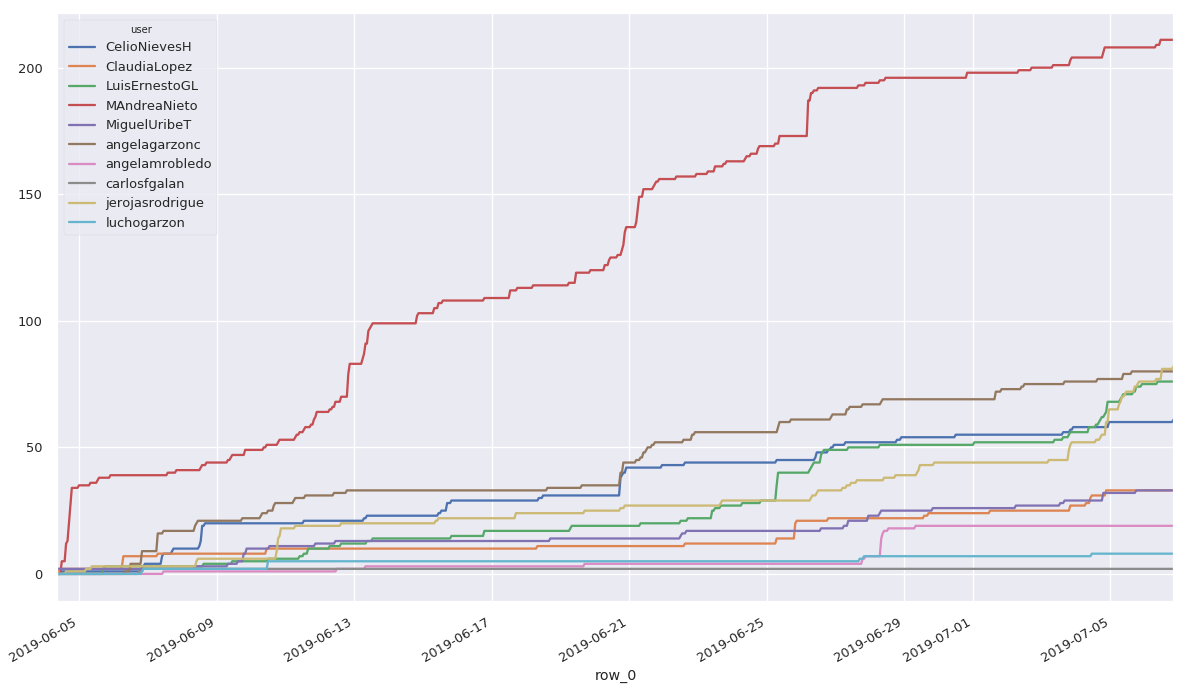

In [48]:
twits_filt_cands.cumsum().plot(figsize=(20,12))# No cuadra este gráfico # Revisar!!!!!!

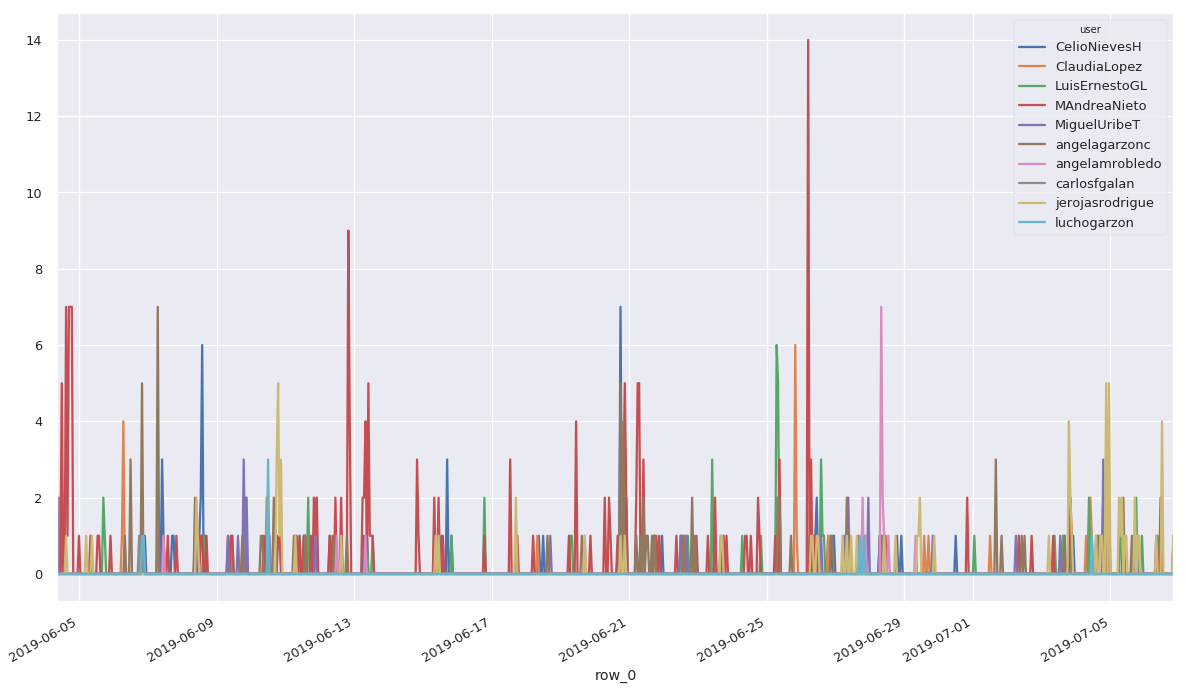

In [49]:
twits_filt_cands.plot(figsize=(20,12))# No cuadra este gráfico # Revisar!!!!!!

# Grafos

In [50]:
mat_size=40
graph_mat=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:mat_size],
                                directed_graph_df.sum(axis=0).sort_values(ascending=False).index[:mat_size]
                               ]
graph_mat.head()

,ClaudiaLopez,petrogustavo,angelamrobledo,HOLLMANMORRIS,MiguelUribeT,GustavoBolivar,EnriquePenalosa,LuisErnestoGL,jerojasrodrigue,carlosfgalan,angelagarzonc,IvanDuque,CarlosCarrilloA,GNavasTalero,CConstitucional,CelioNievesH,PizarroMariaJo,AngelicaLozanoC,AidaAvellaE,DavidRacero,PartidoVerdeCoL,IvanCepedaCast,SaninPazC,merv59,AntanasMockus,sergio_fajardo,AlvaroUribeVel,EpicuroDeSamos_,matadoreltiempo,luchogarzon,DCoronell,GiordanoBrunoFi,MafeCarrascal,TransMilenio,DanielSamperO,ColombiaHumana_,MAndreaNieto,edisonbedoya,JERobledo,intiasprilla
merv59,61.0,334.0,434.0,22.0,4.0,352.0,3.0,3.0,13.0,3.0,1.0,53.0,3.0,23.0,0.0,14.0,295.0,20.0,365.0,275.0,21.0,60.0,171.0,489.0,4.0,9.0,114.0,143.0,68.0,7.0,24.0,81.0,14.0,0.0,31.0,4.0,0.0,291.0,15.0,13.0
LeilaChujfi,125.0,97.0,403.0,34.0,9.0,312.0,7.0,27.0,36.0,0.0,0.0,72.0,35.0,39.0,0.0,15.0,11.0,23.0,249.0,19.0,8.0,22.0,42.0,373.0,1.0,17.0,51.0,19.0,141.0,0.0,87.0,261.0,8.0,1.0,35.0,9.0,0.0,6.0,4.0,1.0
maxmaye15354547,431.0,144.0,35.0,232.0,56.0,49.0,111.0,120.0,54.0,46.0,15.0,2.0,340.0,349.0,0.0,312.0,18.0,14.0,12.0,15.0,74.0,19.0,32.0,20.0,8.0,6.0,5.0,10.0,9.0,38.0,4.0,108.0,15.0,34.0,18.0,32.0,1.0,3.0,71.0,15.0
edisonbedoya,1.0,368.0,383.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,379.0,0.0,382.0,338.0,4.0,48.0,198.0,329.0,0.0,7.0,112.0,163.0,48.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
macdonal5,105.0,230.0,216.0,51.0,18.0,196.0,17.0,2.0,13.0,5.0,9.0,30.0,1.0,14.0,0.0,1.0,167.0,35.0,172.0,148.0,51.0,61.0,99.0,246.0,2.0,62.0,62.0,84.0,60.0,2.0,10.0,2.0,5.0,4.0,24.0,6.0,0.0,179.0,12.0,19.0


In [51]:
graph_mat.shape

(40, 40)

In [0]:
graph_df=graph_mat.melt()
graph_df.columns=["tw_para", "freq"]
graph_df["tw_de"]=[usr for i in range(int(len(graph_df)/len(graph_mat.index)))for usr in list(graph_mat.index)]
graph_df=graph_df.loc[:,["tw_de","tw_para","freq"]]

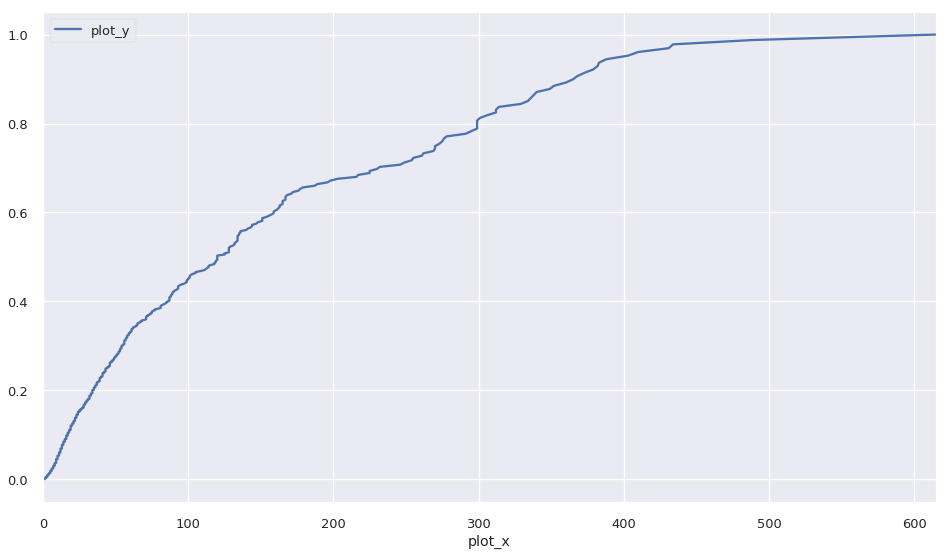

In [53]:
plot_x=np.array(list(graph_df.freq.sort_values(ascending=True)))
plot_y=np.cumsum(plot_x)/sum(plot_x)
cum_freq=pd.DataFrame({"plot_x":plot_x,
                       "plot_y":plot_y})
cum_freq.plot(x="plot_x",
              y="plot_y",
             figsize=(16,9))

In [54]:
min_crit_tw=cum_freq[cum_freq.plot_y>=.3].iloc[0,0]
graph_df_filt=graph_df.loc[graph_df.freq>=min_crit_tw,:]
mx_fr=max(graph_df_filt.freq)
print(min_crit_tw)
print(len(graph_df_filt))
graph_df_filt.sort_values("freq",ascending=False)#.head(20)

55.0
235


,tw_de,tw_para,freq
7,richizuluaga,ClaudiaLopez,615.0
920,merv59,merv59,489.0
80,merv59,angelamrobledo,434.0
2,maxmaye15354547,ClaudiaLopez,431.0
1007,richizuluaga,sergio_fajardo,410.0
81,LeilaChujfi,angelamrobledo,403.0
967,richizuluaga,AntanasMockus,388.0
83,edisonbedoya,angelamrobledo,383.0
723,edisonbedoya,AidaAvellaE,382.0
643,edisonbedoya,PizarroMariaJo,379.0


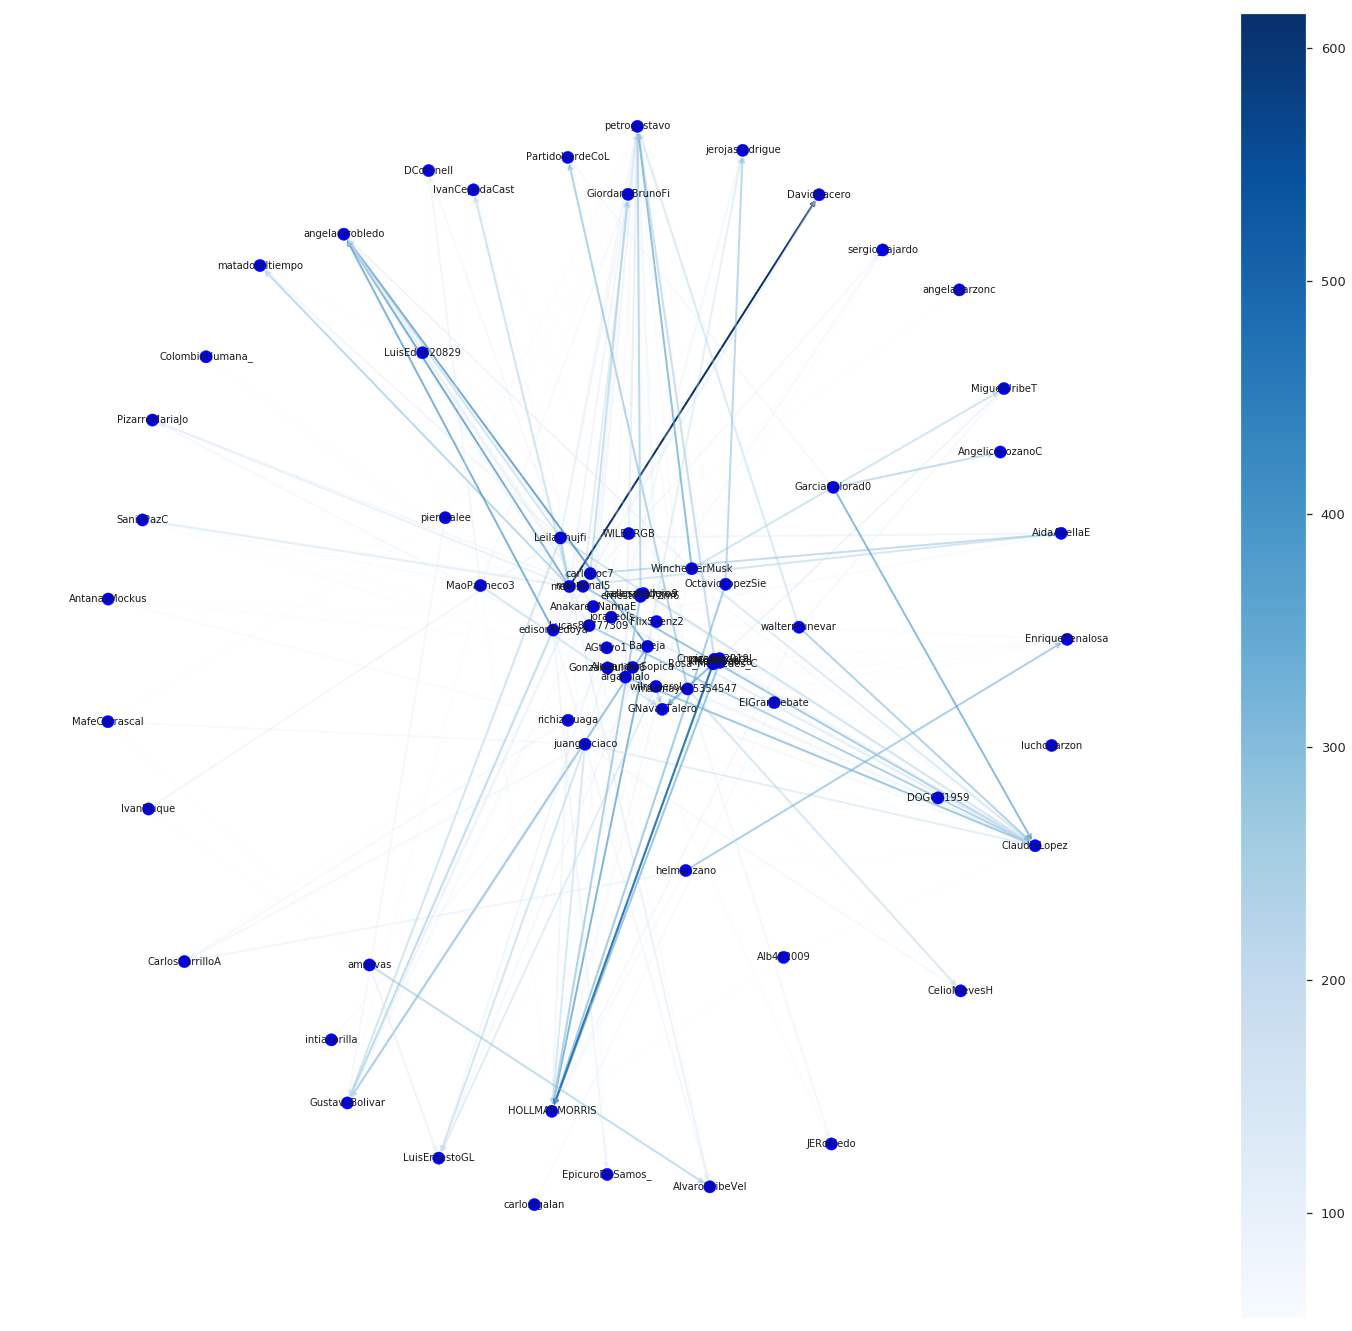

In [55]:
plt.figure(figsize=(26,24))
G= nx.DiGraph()#nx.generators.directed.random_k_out_graph(10, 3, 0.5)
for i, elrow in graph_df_filt.iterrows():
    G.add_edge(elrow[0], elrow[1])

pos = nx.layout.spring_layout(G)

node_sizes = [150 for i in range(len(G))]
M = G.number_of_edges()
edge_colors =[fr for fr in graph_df_filt.freq]#range(2, M + 2)
edge_alphas =[fr/mx_fr for fr in graph_df_filt.freq]#[fr/mx_fr for fr in graph_df_filt.freq]#[(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

nx.draw_networkx_labels(G, pos, font_size=10)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [0]:
g = nx.Graph()


In [0]:
for i, elrow in graph_df_filt.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [58]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 234
# of nodes: 73


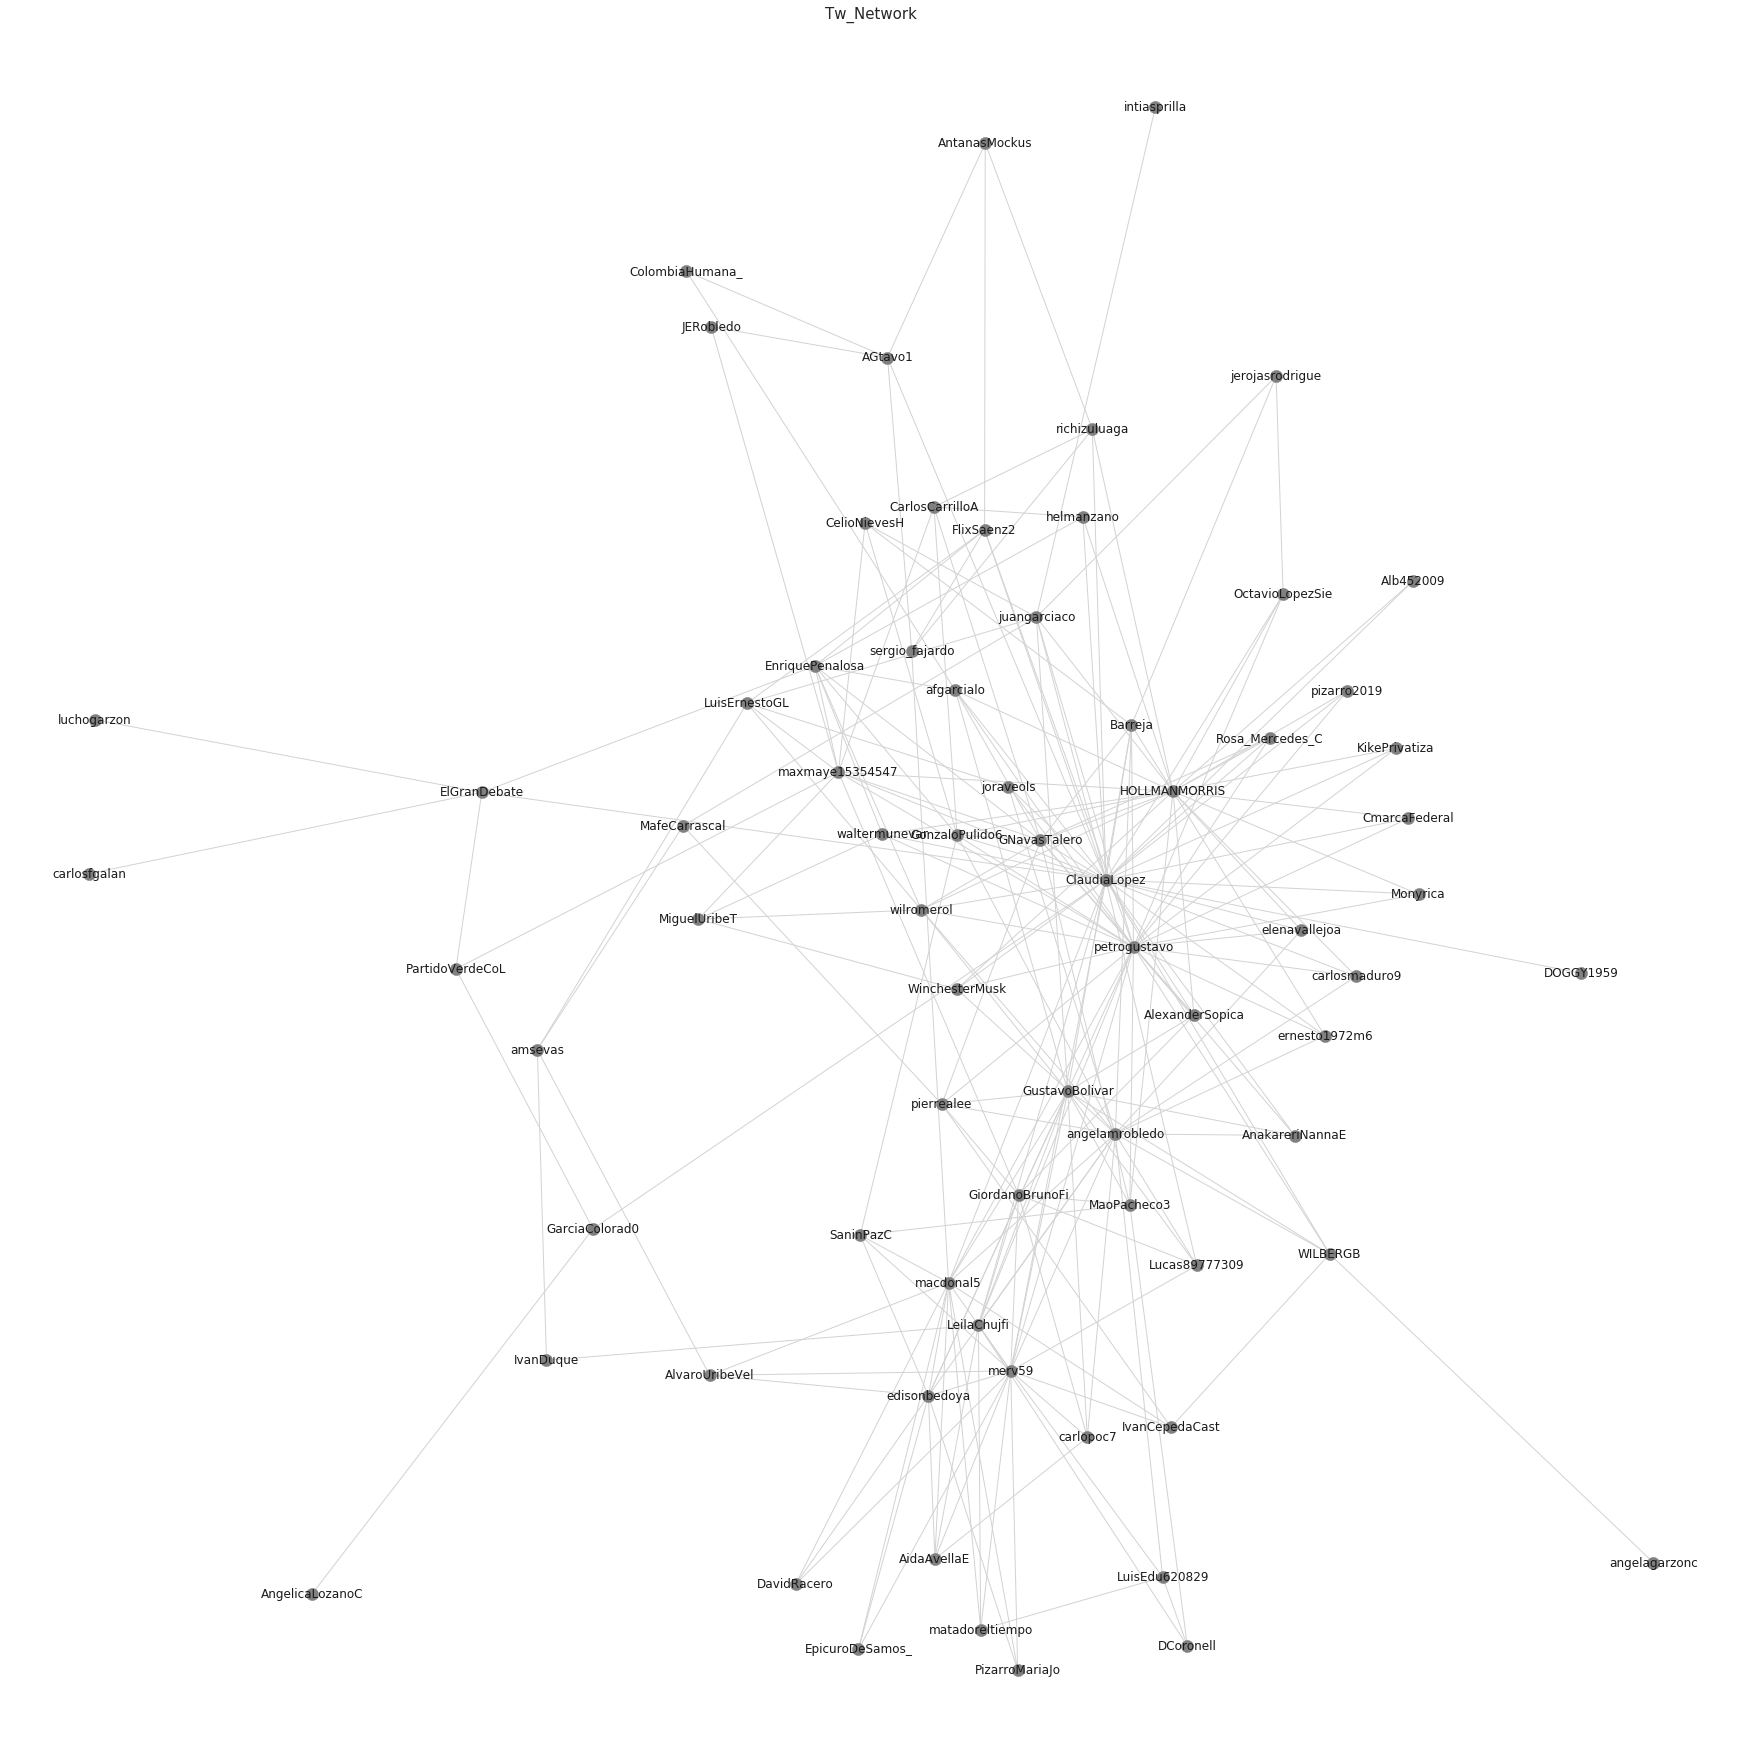

In [59]:
plt.figure(figsize=(24, 24))
nx.draw(g,
        node_size=150,
        edge_color='lightgray',
        node_color='gray',
        with_labels=True)
plt.title('Tw_Network', size=15)
plt.show()
# plt.savefig('tweets_net.png')